# FloPy

## MODPATH 7 structured models example

This notebook demonstrates how to create and run example 1a from the MODPATH 7 documentation for MODFLOW-2005 and MODFLOW 6. The notebooks also shows how to create subsets of endpoint output and plot MODPATH results on PlotMapView objects.

In [1]:
import sys
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# run installed version of flopy or add local path
try:
    import flopy
except:
    fpth = os.path.abspath(os.path.join('..', '..'))
    sys.path.append(fpth)
    import flopy

    print(sys.version)
print('numpy version: {}'.format(np.__version__))
print('matplotlib version: {}'.format(mpl.__version__))
print('flopy version: {}'.format(flopy.__version__))

if not os.path.exists("data"):
    os.mkdir("data")

numpy version: 1.18.5
matplotlib version: 3.2.2
flopy version: 3.3.3


### Flow model data

In [2]:
nper, nstp, perlen, tsmult = 1, 1, 1., 1.
nlay, nrow, ncol = 3, 21, 20
delr = delc = 500.
top = 400.
botm = [220., 200., 0.]
laytyp = [1, 0, 0]
kh = [50., 0.01, 200.]
kv = [10., 0.01, 20.]
wel_loc = (2, 10, 9)
wel_q = -150000.
rch = 0.005
riv_h = 320.
riv_z = 317.
riv_c = 1.e5

### MODPATH 7 data

In [3]:
# MODPATH zones
zone3 = np.ones((nrow, ncol), dtype=np.int32)
zone3[wel_loc[1:]] = 2
zones = [1, 1, zone3]

# create particles
# particle group 1
plocs = []
pids = []
for idx in range(nrow):
    plocs.append((0, idx, 2))
    pids.append(idx)
part0 = flopy.modpath.ParticleData(plocs, drape=0, structured=True, particleids=pids)
pg0 = flopy.modpath.ParticleGroup(particlegroupname='PG1', particledata=part0,
                                  filename='ex01a.pg1.sloc')

# particle group 2
v = [(2, 0, 0), (0, 20, 0)]
part1 = flopy.modpath.ParticleData(v, drape=1, structured=True, particleids=[1000, 1001])
pg1 = flopy.modpath.ParticleGroup(particlegroupname='PG2', particledata=part1,
                                  filename='ex01a.pg2.sloc')

locsa = [[0, 0, 0, 0, nrow - 1, ncol - 1],
             [1, 0, 0, 1, nrow - 1, ncol - 1]]
locsb = [[2, 0, 0, 2, nrow - 1, ncol - 1]]
sd = flopy.modpath.CellDataType(drape=0, columncelldivisions=1,
                                rowcelldivisions=1, layercelldivisions=1)
p = flopy.modpath.LRCParticleData(subdivisiondata=[sd, sd],
                                  lrcregions=[locsa, locsb])
pg2 = flopy.modpath.ParticleGroupLRCTemplate(particlegroupname='PG3',
                                                particledata=p,
                                                filename='ex01a.pg3.sloc')

particlegroups = [pg2]

# default iface for MODFLOW-2005 and MODFLOW 6
defaultiface = {'RECHARGE': 6, 'ET': 6}
defaultiface6 = {'RCH': 6, 'EVT': 6}

### MODPATH 7 using MODFLOW-2005

#### Create and run MODFLOW-2005

In [4]:
ws = os.path.join('data', 'mp7_ex1', 'mf2005')
nm = 'ex01_mf2005'
exe_name = 'mf2005'
iu_cbc = 130
m = flopy.modflow.Modflow(nm, model_ws=ws,
                          exe_name=exe_name)
flopy.modflow.ModflowDis(m, nlay=nlay, nrow=nrow, ncol=ncol,
                         nper=nper, itmuni=4 , lenuni=1,
                         perlen=perlen, nstp=nstp,
                         tsmult=tsmult, steady=True,
                         delr=delr, delc=delc,
                         top=top, botm=botm)
flopy.modflow.ModflowLpf(m, ipakcb=iu_cbc, laytyp=laytyp, hk=kh, vka=kv, constantcv=True)
flopy.modflow.ModflowBas(m, ibound=1, strt=top)
# recharge
flopy.modflow.ModflowRch(m, ipakcb=iu_cbc, rech=rch)
# wel
wd = [i for i in wel_loc] + [wel_q]
flopy.modflow.ModflowWel(m, ipakcb=iu_cbc, stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([0, i, ncol-1, riv_h, riv_c, riv_z])
flopy.modflow.ModflowRiv(m, ipakcb=iu_cbc, stress_period_data={0: rd})
# output control
flopy.modflow.ModflowOc(m, stress_period_data={(0, 0): ['save head',
                                                        'save budget',
                                                        'print head']})
flopy.modflow.ModflowPcg(m, hclose=1e-6, rclose=1e-6)

m.write_input()
success, buff = m.run_model()
assert success, 'mf2005 model did not run'

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf2005

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: ex01_mf2005.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/02/18 11:33:53

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/02/18 11:33:53
 Elapsed run time:  0.015 Seconds

  Normal termination of simulation


In [5]:
# this is a fix until the grid object is available
m.sr = flopy.utils.SpatialReference(xll=0, yll=0, delr=m.dis.delr.array, delc=m.dis.delc.array, 
                                    units='meters', lenuni=1, length_multiplier=1)

#### Create and run MODPATH 7

In [6]:
# create modpath files
exe_name = 'mp7'
mp = flopy.modpath.Modpath7(modelname=nm + '_mp', flowmodel=m,
                            exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1,
                                  defaultiface=defaultiface)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  budgetcellnumbers=[1049, 1259],
                                  traceparticledata=[1, 1000],
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='extend',
                                  timepointdata=[500, 1000.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=particlegroups)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Oct 29 2020 12:30:37 with IFORT compiler (ver. 19.10.3)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    



Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1260 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 output

Get locations to extract pathline data

In [7]:
nodew = m.dis.get_node([wel_loc])
riv_locs = flopy.utils.ra_slice(m.riv.stress_period_data[0], ['k', 'i', 'j'])
nodesr = m.dis.get_node(riv_locs.tolist())

Pathline data

In [8]:
fpth = os.path.join(ws, nm + '_mp.mppth')
p = flopy.utils.PathlineFile(fpth)
pw0 = p.get_destination_pathline_data(nodew)
pr0 = p.get_destination_pathline_data(nodesr)

Endpoint data

Get particles that terminate in the well

In [9]:
fpth = os.path.join(ws, nm + '_mp.mpend')
e = flopy.utils.EndpointFile(fpth)
well_epd = e.get_destination_endpoint_data(dest_cells=nodew) 
well_epd.shape

(564,)

Get particles that terminate in the river boundaries

In [10]:
riv_epd = e.get_destination_endpoint_data(dest_cells=nodesr)
riv_epd.shape

(696,)

Merge the particles that end in the well and the river boundaries.

In [11]:
epd0 = np.concatenate((well_epd, riv_epd))
epd0.shape

(1260,)

#### Plot MODPATH 7 output

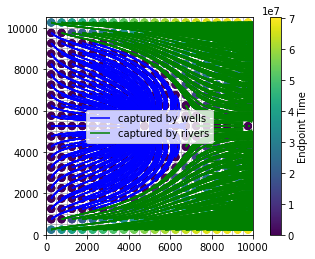

In [12]:
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw0, layer='all', color='blue', label='captured by wells')
mm.plot_pathline(pr0, layer='all', color='green', label='captured by rivers')
mm.plot_endpoint(epd0, direction='starting', colorbar=True)
mm.ax.legend();

### MODPATH 7 using MODFLOW 6

#### Create and run MODFLOW 6

In [13]:
ws = os.path.join('data', 'mp7_ex1', 'mf6')
nm = 'ex01_mf6'
exe_name = 'mf6'

# Create the Flopy simulation object
sim = flopy.mf6.MFSimulation(sim_name=nm, exe_name='mf6',
                             version='mf6', sim_ws=ws)

# Create the Flopy temporal discretization object
pd = (perlen, nstp, tsmult)
tdis = flopy.mf6.modflow.mftdis.ModflowTdis(sim, pname='tdis',
                                            time_units='DAYS', nper=nper,
                                            perioddata=[pd])

# Create the Flopy groundwater flow (gwf) model object
model_nam_file = '{}.nam'.format(nm)
gwf = flopy.mf6.ModflowGwf(sim, modelname=nm,
                           model_nam_file=model_nam_file, save_flows=True)

# Create the Flopy iterative model solver (ims) Package object
ims = flopy.mf6.modflow.mfims.ModflowIms(sim, pname='ims', 
                                         complexity='SIMPLE',
                                         outer_hclose=1e-6,
                                         inner_hclose=1e-6,
                                         rcloserecord=1e-6)

# create gwf file
dis = flopy.mf6.modflow.mfgwfdis.ModflowGwfdis(gwf, pname='dis', nlay=nlay,
                                               nrow=nrow, ncol=ncol,
                                               length_units='FEET',
                                               delr=delr, delc=delc,
                                               top=top,
                                               botm=botm)
# Create the initial conditions package
ic = flopy.mf6.modflow.mfgwfic.ModflowGwfic(gwf, pname='ic', strt=top)

# Create the node property flow package
npf = flopy.mf6.modflow.mfgwfnpf.ModflowGwfnpf(gwf, pname='npf',
                                               icelltype=laytyp, k=kh,
                                               k33=kv)


# recharge
flopy.mf6.modflow.mfgwfrcha.ModflowGwfrcha(gwf, recharge=rch)
# wel
wd = [(wel_loc, wel_q)]
flopy.mf6.modflow.mfgwfwel.ModflowGwfwel(gwf, maxbound=1,
                                         stress_period_data={0: wd})
# river
rd = []
for i in range(nrow):
    rd.append([(0, i, ncol - 1), riv_h, riv_c, riv_z])
flopy.mf6.modflow.mfgwfriv.ModflowGwfriv(gwf, stress_period_data={0: rd})
# Create the output control package
headfile = '{}.hds'.format(nm)
head_record = [headfile]
budgetfile = '{}.cbb'.format(nm)
budget_record = [budgetfile]
saverecord = [('HEAD', 'ALL'),
              ('BUDGET', 'ALL')]
oc = flopy.mf6.modflow.mfgwfoc.ModflowGwfoc(gwf, pname='oc',
                                            saverecord=saverecord,
                                            head_filerecord=head_record,
                                            budget_filerecord=budget_record)

# Write the datasets
sim.write_simulation()
# Run the simulation
success, buff = sim.run_simulation()
assert success, 'mf6 model did not run'

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing ims package ims...
  writing model ex01_mf6...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package rcha...
    writing package wel_0...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
    writing package oc...
FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.2.0 10/22/2020

   MODFLOW 6 compiled Oct 29 2020 12:19:52 with IFORT compiler (ver. 19.10.3)

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the sof

#### Create and run MODPATH 7

In [14]:
# create modpath files
exe_name = 'mp7'
mp = flopy.modpath.Modpath7(modelname=nm + '_mp', flowmodel=gwf,
                            exe_name=exe_name, model_ws=ws)
mpbas = flopy.modpath.Modpath7Bas(mp, porosity=0.1,
                                  defaultiface=defaultiface6)
mpsim = flopy.modpath.Modpath7Sim(mp, simulationtype='combined',
                                  trackingdirection='forward',
                                  weaksinkoption='pass_through',
                                  weaksourceoption='pass_through',
                                  budgetoutputoption='summary',
                                  budgetcellnumbers=[1049, 1259],
                                  traceparticledata=[1, 1000],
                                  referencetime=[0, 0, 0.],
                                  stoptimeoption='extend',
                                  timepointdata=[500, 1000.],
                                  zonedataoption='on', zones=zones,
                                  particlegroups=particlegroups)

# write modpath datasets
mp.write_input()

# run modpath
mp.run_model()

FloPy is using the following  executable to run the model: /Users/jdhughes/.local/bin/mp7

MODPATH Version 7.2.001   
Program compiled Oct 29 2020 12:30:37 with IFORT compiler (ver. 19.10.3)        
 
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00  Steady-state flow                                                    



Particle Summary:
         0 particles are pending release.
         0 particles remain active.
         0 particles terminated at boundary faces.
         0 particles terminated at weak sink cells.
         0 particles terminated at weak source cells.
      1260 particles terminated at strong source/sink cells.
         0 particles terminated in cells with a specified zone number.
         0 particles were stranded in inactive or dry cells.
         0 particles were unreleased.
         0 particles have an unknown status.
 
Normal termination.                                                        


(True, [])

#### Load MODPATH 7 output

Pathline data

In [15]:
fpth = os.path.join(ws, nm + '_mp.mppth')
p = flopy.utils.PathlineFile(fpth)
pw1 = p.get_destination_pathline_data(nodew)
pr1 = p.get_destination_pathline_data(nodesr)

Endpoint data

Get particles that terminate in the well

In [16]:
fpth = os.path.join(ws, nm + '_mp.mpend')
e = flopy.utils.EndpointFile(fpth)
well_epd = e.get_destination_endpoint_data(dest_cells=nodew) 

Get particles that terminate in the river boundaries

In [17]:
riv_epd = e.get_destination_endpoint_data(dest_cells=nodesr)

Merge the particles that end in the well and the river boundaries.

In [18]:
epd1 = np.concatenate((well_epd, riv_epd))

### Plot MODPATH 7 output

Use MODFLOW-2005 model for plotting (until MODFLOW 6 grid object implemented)

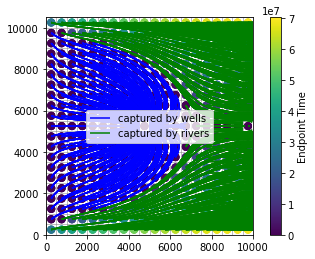

In [19]:
mm = flopy.plot.PlotMapView(model=m)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw1, layer='all', color='blue', label='captured by wells')
mm.plot_pathline(pr1, layer='all', color='green', label='captured by rivers')
mm.plot_endpoint(epd1, direction='starting', colorbar=True)
mm.ax.legend();

### Compare MODPATH results

Compare MODPATH results for MODFLOW-2005 and MODFLOW 6. Also show pathline points every 5th point.

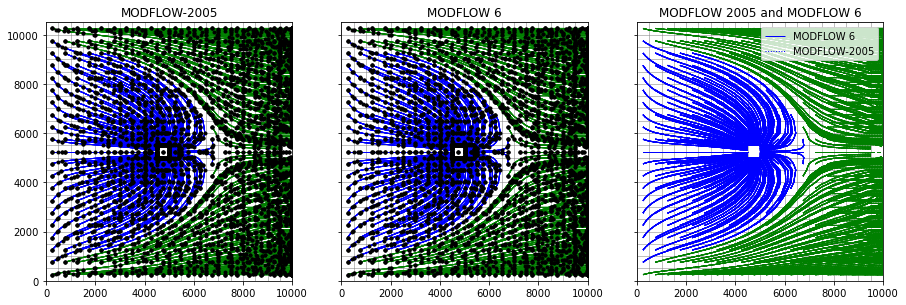

In [20]:
f, axes = plt.subplots(ncols=3, nrows=1, sharey=True, figsize=(15, 10))
axes = axes.flatten()
ax = axes[0]
ax.set_aspect('equal')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw0, layer='all', color='blue', lw=1,
                 marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pr0, layer='all', color='green', lw=1,
                 marker='o', markercolor='black', markersize=3, markerevery=5)
ax.set_title('MODFLOW-2005')

ax = axes[1]
ax.set_aspect('equal')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw1, layer='all', color='blue', lw=1,
                 marker='o', markercolor='black', markersize=3, markerevery=5)
mm.plot_pathline(pr1, layer='all', color='green', lw=1,
                 marker='o', markercolor='black', markersize=3, markerevery=5)
ax.set_title('MODFLOW 6')


ax = axes[2]
ax.set_aspect('equal')
mm = flopy.plot.PlotMapView(model=m, ax=ax)
mm.plot_grid(lw=0.5)
mm.plot_pathline(pw1, layer='all', color='blue', lw=1, label='MODFLOW 6')
mm.plot_pathline(pw0, layer='all', color='blue', lw=1, linestyle=':', label='MODFLOW-2005')
mm.plot_pathline(pr1, layer='all', color='green', lw=1, label='_none')
mm.plot_pathline(pr0, layer='all', color='green', lw=1, linestyle=':', label='_none')
ax.legend()
ax.set_title('MODFLOW 2005 and MODFLOW 6');